# Исследование данных о российском кинопрокате
## Описание проекта
- Заказчик: Министерство культуры Российской Федерации. 
- Цель: Изучить рынок российского кинопроката и выявить текущие тренды, в том числе особенности фильмов, которые получили государственную поддержку. Выявить, насколько такие фильмы интересны зрителю. 
- Источник: Данные, опубликованные на портале открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск. 

### 1.1 Подготовка данных для работы
Откроем файлы с данными и объединим их в один датафрейм таким образом, чтобы все объекты из датасета mkrf_movies обязательно вошли в получившийся датафрейм.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.float_format = '{:,.0f}'.format

# данные о прокатных удостоверениях
df_1 = pd.read_csv('/mkrf_movies.csv')
#данные о прокате в российских кинотеатрах. 
df_2 = pd.read_csv('/mkrf_shows.csv')

In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [4]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


In [5]:
# Т.к. объединять нужно по номеру прокатного удостоверения, сначала взглянем, не дублирутеся ли он.
df_1['puNumber'].duplicated().sum()

2

In [6]:
# Есть дубликаты в первом датасете
df_1.loc[df_1['puNumber'].duplicated()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17T12:00:00.000Z,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история"
5068,Анализируй то!,221054410,2010-05-25T12:00:00.000Z,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал"


In [7]:
df_2['puNumber'].duplicated().sum()

0

In [8]:
# Во втором датафрейме нет дубликатов.
# Удалим дубликаты в первом.
df_1 = df_1.drop_duplicates('puNumber', keep='first').reset_index(drop=True)

In [9]:
# В первом датафрейме неправильно указан тип переменной для номера (строка), изменим тип.
# при вызове "df_1['puNumber'] = df_1['puNumber'].astype('int')" возвращает ошибку, ValueError, т.к. присутствует string 'нет'. 
# Поэтому, сначала обработаетм это.
df_1.query('puNumber == "нет"')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_1['puNumber'].replace('нет', 0, inplace=True)
df_1['puNumber'] = df_1['puNumber'].astype('int')

# Объединяем датафреймы так, чтобы данные из обоих датафреймов попали в обхединённый датасет.
df = df_1.merge(df_2, on='puNumber', how='outer')
df.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


In [11]:
if df['puNumber'].duplicated().any():
    print("Duplicate primary keys found in merged dataset.")
else:
    print("No duplicate primary keys found in merged dataset.")

No duplicate primary keys found in merged dataset.


#### Промежуточный вывод 1: ### 
Скачаны, открыты файлы с даннымми, преобразован некорректно указанный тип для номера прокатной лицензии. 
Данные объединены в один датафрейм c помощью типа объединения, который позволяет сделать объединение так, что получившийся набор данных содержит информацию из обоих файлов.

### 1.2  Предобработка данных

In [12]:
# Проверим типы данных в датафрейме и преобразуем их там, где это необходимо.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7484 entries, 0 to 7483
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7484 non-null   object 
 1   puNumber               7484 non-null   int64  
 2   show_start_date        7484 non-null   object 
 3   type                   7484 non-null   object 
 4   film_studio            7466 non-null   object 
 5   production_country     7482 non-null   object 
 6   director               7475 non-null   object 
 7   producer               6916 non-null   object 
 8   age_restriction        7484 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6517 non-null   object 
 14  genres                 6508 non-null   object 
 15  box_

In [13]:
# Преобразуем столбец с датой и сразу выделим год для последующего анализа
df['show_start_date'] = pd.to_datetime(df['show_start_date'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['year'] = df['show_start_date'].dt.year

In [14]:
# Преобразуем столбец с рейтингом - приведём все рейтинги к единому формату
df['ratings'] = df['ratings'].replace('%', '', regex=True)
df['ratings'] = df['ratings'].astype(float)
for i, rating in enumerate(df['ratings']):
    if rating > 10:
        df.loc[i, 'ratings'] = (rating / 100) * 10

In [15]:
df['ratings'].unique()

array([7.2, 6.6, 6.8, 7.7, 8.3, 8. , 7.8, 8.1, 7.1, 6. , 7.4, 5.8, 8.7,
       6.3, 6.9, 5. , 4.3, 7.3, 7. , 6.4, nan, 8.2, 7.5, 6.7, 7.9, 5.9,
       6.2, 5.6, 6.5, 2.4, 7.6, 6.1, 8.6, 8.5, 8.8, 5.5, 5.1, 5.7, 5.4,
       9.9, 4.4, 4.5, 5.3, 4.1, 8.4, 2.6, 3.8, 4.6, 4.8, 4. , 3. , 1.6,
       4.2, 5.2, 4.7, 4.9, 3.9, 2.7, 3.3, 2.9, 2.8, 3.7, 1.4, 3.1, 9.7,
       3.5, 3.2, 2.8, 1.5, 2.1, 2.5, 9.2, 3.4, 1.1, 3.6, 8.3, 9.1, 9.4,
       9. , 1.9, 1. , 8.9, 1.3, 1.8, 1.2, 1.7, 9.8])

In [16]:
# Посмотрим на кол-во пропусков в датафрейме.
df.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7152
nonrefundable_support    7152
budget                   7152
financing_source         7152
ratings                   967
genres                    976
box_office               4326
year                        0
dtype: int64

In [17]:
# Также, посмотрим, есть ли явные дубликаты.
df.duplicated().sum()

0

In [18]:
# Строк-дубликатов нет.
# Изучим более детально столбцы и посмотрим, есть ли там ненужные дубликаты, и возможно ли чем-то заполнить пропуски.

# Столбец со студиями.
df['film_studio'].unique()

array(['Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикчерз, Тиг Продакшнз',
       'Киностудия "Мосфильм"',
       'Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Платт Продакшнз, Рилейтивити Медиа, Спайгласс Интертейнмент, Стилкин Филмз, Топ Кау Продакшнз',
       ...,
       'Дэниел Гродник Продакшнз, Вандерфилм Медиа Корпорэйшн, Импринт Интертейнмент, Вор Хорс Интертейнмент, Пимиента ',
       'Никелодеон Анимейшн Студиос, Спин Мастер',
       'Анимаккорд Лтд., ООО Студия "АНИМАККОРД"'], dtype=object)

In [19]:
# Очень много комбинаций в столбцах со студиями, жанрами, продюссерами для каждого фильма. 
# Сократим такие описания, оставив в качестве основной студии первое значение.

def extract_primary(df, column_name):
    new_column_name = column_name + '_primary'
    df[new_column_name] = df[column_name].str.split(',').str[0]
    return df

df = extract_primary(df, 'film_studio')
df = extract_primary(df, 'genres')
df = extract_primary(df, 'producer')

# Тоже повторим для режисёров
df = extract_primary(df, 'director')

In [20]:
df.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,budget,financing_source,ratings,genres,box_office,year,film_studio_primary,genres_primary,producer_primary,director_primary
0,Открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,...,NaN,NaN,7,"боевик,драма,мелодрама",NaN,2015,Тачстоун Пикчерз,боевик,Дэвид Валдес,Кевин Костнер
1,Особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,...,NaN,NaN,7,"драма,военный",NaN,2016,"Киностудия ""Мосфильм""",драма,NaN,Е.Матвеев
2,Особо опасен,221038416,2016-10-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,...,NaN,NaN,7,"фантастика,боевик,триллер",NaN,2016,Юниверсал Пикчерз,фантастика,Джим Лемли,Тимур Бекмамбетов
3,Особо опасен,221026916,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,...,NaN,NaN,7,"фантастика,боевик,триллер",NaN,2016,Юниверсал Пикчерз,фантастика,Джим Лемли,Тимур Бекмамбетов
4,Особо опасен,221030815,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,...,NaN,NaN,7,"фантастика,боевик,триллер",NaN,2015,Юниверсал Пикчерз,фантастика,Джим Лемли,Тимур Бекмамбетов


In [21]:
df['age_restriction'].unique()

array(['«18+» - запрещено для детей', '«6+» - для детей старше 6 лет',
       '«12+» - для детей старше 12 лет',
       '«16+» - для детей старше 16 лет',
       '«0+» - для любой зрительской аудитории'], dtype=object)

In [22]:
# Столбец с описанием возрастного ограничения также требует обработки. Уберём лишнее.
def age_short(text):
    age_mapping = {
        '0+': '0+',
        '12+': '12+',
        '16+': '16+',
        '18+': '18+',
        '6+': '6+'
    }
    for key in age_mapping:
        if key in text:
            return age_mapping[key]
    return None

df['age_restriction'] = df['age_restriction'].apply(age_short)

df['age_restriction'].unique()

array(['18+', '6+', '12+', '16+', '0+'], dtype=object)

In [23]:
df.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,budget,financing_source,ratings,genres,box_office,year,film_studio_primary,genres_primary,producer_primary,director_primary
0,Открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",18+,NaN,...,NaN,NaN,7,"боевик,драма,мелодрама",NaN,2015,Тачстоун Пикчерз,боевик,Дэвид Валдес,Кевин Костнер
1,Особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,6+,NaN,...,NaN,NaN,7,"драма,военный",NaN,2016,"Киностудия ""Мосфильм""",драма,NaN,Е.Матвеев
2,Особо опасен,221038416,2016-10-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18+,NaN,...,NaN,NaN,7,"фантастика,боевик,триллер",NaN,2016,Юниверсал Пикчерз,фантастика,Джим Лемли,Тимур Бекмамбетов
3,Особо опасен,221026916,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18+,NaN,...,NaN,NaN,7,"фантастика,боевик,триллер",NaN,2016,Юниверсал Пикчерз,фантастика,Джим Лемли,Тимур Бекмамбетов
4,Особо опасен,221030815,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18+,NaN,...,NaN,NaN,7,"фантастика,боевик,триллер",NaN,2015,Юниверсал Пикчерз,фантастика,Джим Лемли,Тимур Бекмамбетов


In [24]:
# Может быть наличие пробелов в начале/конце строковых значений, обработаем это.
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.strip()
        

In [25]:
# Ещё раз посомтрим на кол-во пропусков
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

title - 0%
puNumber - 0%
show_start_date - 0%
type - 0%
film_studio - 0%
production_country - 0%
director - 0%
producer - 8%
age_restriction - 0%
refundable_support - 96%
nonrefundable_support - 96%
budget - 96%
financing_source - 96%
ratings - 13%
genres - 13%
box_office - 58%
year - 0%
film_studio_primary - 0%
genres_primary - 13%
producer_primary - 8%
director_primary - 0%


Данные о возвратной и невозвратной поддержке, общем бюджете фильма, источниках финансирования, рейтинге на КиноПоиске и сборах в прокате имеют высокий процент пропусков (96% для поддержки и бюджета, 58% для сборов в прокате). Однако, удалять их нельзя, т.к. потерятеся много данных.
Логичных вариантов заполнения также предложить не могу, поэтому, оставим пропуски в данных.

In [26]:
# Относительно неявных дубликатов по столбцам, вполне ожидаемо, что названия студий, режисеров, продюссеров и т.д. буду повторяться, это логично, т.к. один и тот же режисер,
# студия и т.п. могут быть задействованы для разных фильмов.
# Посмотрим на столбец с названиями фильмов.
df['title'].duplicated().sum()

713

In [27]:
# Названия фильмов дублируются, но прокатные лиценции нет. Существуют случаи, когда фильм может иметь несколько прокатных удостоверений.
# Например, если фильм изменяется для показа в разных странах или если он переиздается с дополнительными материалами или изменениями, 
# которые требуют нового удостоверения. Также может потребоваться дополнительное удостоверение, если фильм изменяется для показа в различных 
# форматах или на различных платформах (например, в 2D и 3D форматах или для IMAX).

#  Оставим такие строки.

array([[<AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'refundable_support'}>],
       [<AxesSubplot:title={'center':'nonrefundable_support'}>,
        <AxesSubplot:title={'center':'box_office'}>]], dtype=object)

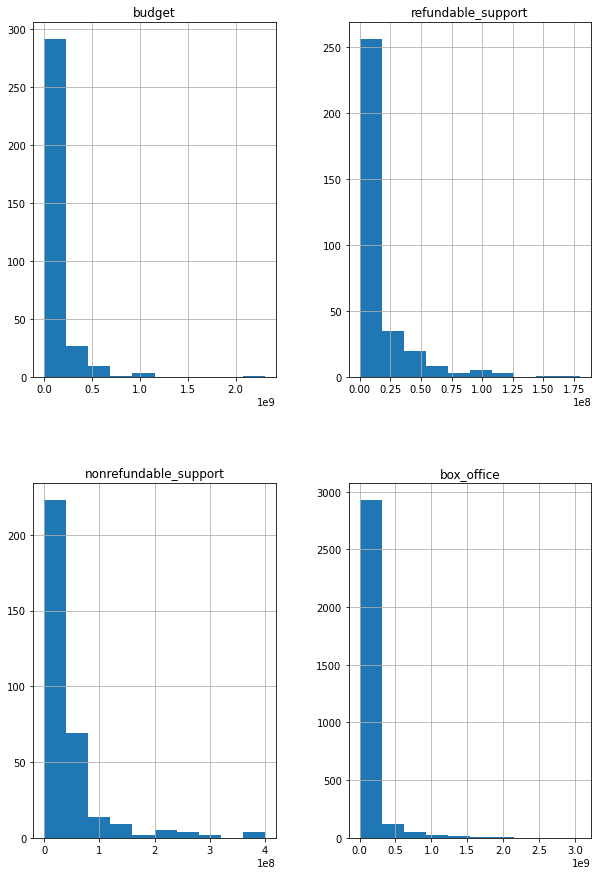

In [28]:
# Посмотрим количественные значения
df[['budget', 'refundable_support', 'nonrefundable_support', 'box_office']].hist(figsize=(10, 15))

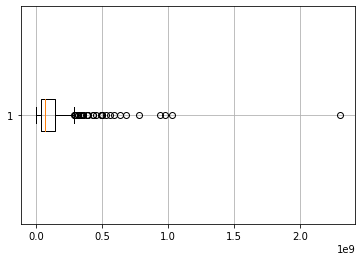

In [29]:
plt.boxplot(df['budget'].dropna(), vert=False)
plt.grid(True)
plt.show()

In [30]:
df['budget'].describe()

count             332
mean      127,229,717
std       188,588,333
min                 0
25%        42,000,000
50%        68,649,916
75%       141,985,320
max     2,305,074,303
Name: budget, dtype: float64

In [31]:
# Вижу, что в столбце с бюджетом есть значения равные 0, а также, смущает один выброс.
# Удалим выброс.
df = df.query('(budget < 2.305074e+09) or budget.isna()')

# Значение 0 в budget выглядит странно, т.к. известно, что данные в этом столбце указаны только для тех фильмов, которые уже получили государственную поддержку.
# Предположу, что это из-за того, что полный бюджет фильма не известен.
# Можно попробовать исправить нулевые значения на сумму значений из колонок с возвртной и невозвратной гос. поддержкой, чтобы не стояли нули и не заменять на NaN.

df['budget'] = df['budget'].where(
    df['budget'] > 0,
    df['refundable_support'] + df['nonrefundable_support']
    )

In [32]:
df.query('budget == 0')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,budget,financing_source,ratings,genres,box_office,year,film_studio_primary,genres_primary,producer_primary,director_primary


In [33]:
# Посчитаем, какую долю от общего бюджета фильма составляет государственная поддержка.
df['support_budget_ratio'] = round((df['refundable_support'] + df['nonrefundable_support']) / df['budget'] * 100)

In [34]:
df[df['support_budget_ratio'].notna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,financing_source,ratings,genres,box_office,year,film_studio_primary,genres_primary,producer_primary,director_primary,support_budget_ratio
1281,Пока еще жива,111005313,2013-10-11 12:00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",16+,0,...,Министерство культуры,8,"драма,мелодрама","365,354",2013,"АНО содействия развитию кинематографии ""Ангел-...",драма,А.Атанесян,А.Атанесян,33
1448,Бесславные придурки,111003314,2014-03-28 12:00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,12+,0,...,Министерство культуры,NaN,NaN,"28,140",2014,"ООО ""Компания ""АТК-Студио""",NaN,А.Тютрюмов,А.Якимчук,70
1498,Невидимки,111004213,2013-09-10 12:00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",12+,0,...,Фонд кино,5,"комедия,фантастика","19,957,032",2013,"ООО ""Компания ""РЕАЛ-ДАКОТА""",комедия,Р.Давлетьяров,Р.Давлетьяров,61
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,16+,0,...,Министерство культуры,4,драма,"55,918",2014,"ООО ""Студия ""Пассажир""",драма,Л.Антонова,Е.Миндадзе (псевдоним Катя Шагалова),69
1792,Братья Ч,111004414,2014-04-23 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",16+,0,...,Министерство культуры,6,драма,"232,100",2014,"ООО ""Студия ""Пассажир""",драма,А.Миндадзе,М.Угаров,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7462,Союз спасения,111022019,2019-12-26 12:00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",12+,"100,000,000",...,Фонд кино,6,"история,биография,драма","717,703,186",2019,"ЗАО ""Дирекция кино""",история,А.Максимов,А.Кравчук,51
7464,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",6+,"100,000,000",...,Фонд кино,7,"мультфильм,приключения,семейный","501,069,235",2019,"ООО ""Студия анимационного кино ""Мельница""",мультфильм,С.Сельянов,Д.Шмидт,53
7472,Вторжение,111022519,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",12+,"100,000,000",...,Фонд кино,6,"фантастика,боевик",NaN,2019,"ООО ""Арт Пикчерс Студия""",фантастика,Ф.Бондарчук,Ф.Бондарчук,53
7474,Я свободен,111023019,2019-12-26 12:00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,12+,0,...,Министерство культуры,6,драма,NaN,2019,"АО ""ТПО ""Киностудия им. М.Горького""",драма,С.Зернов,И.Северов,65


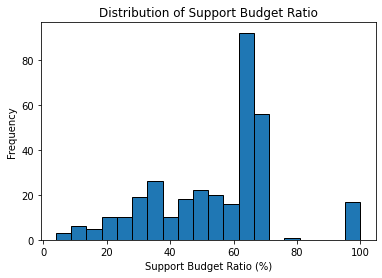

In [35]:
plt.hist(df['support_budget_ratio'], bins=20, edgecolor='black')
plt.title('Distribution of Support Budget Ratio')
plt.xlabel('Support Budget Ratio (%)')
plt.ylabel('Frequency')
plt.show()

In [36]:
# Больше всего в имеющемся наборе данных фильмов, где государственная поддержка составляет около 65% от общего бюджета фильма.

#### Промежуточный вывод 2: ### 
- Выполнена проверка типов данных в датафрейме и преобразование где это необходимо (дата, рейтинг).
- Проанализированы неявные дубликаты, устранены пробелы в начале/конце строковых значений, отредактированы данные с названиям студий, продюссеров, жанров и возрастных ограничений для более удобной работы.
- Устранен выброс.
- Выявлено, что больше всего в имеющемся наборе данных фильмов, где государственная поддержка составляет около 65% от общего бюджета фильма.

### 1.3  Исследовательский анализ данных

In [37]:
# Посмотрим, сколько фильмов выходило в прокат каждый год.
df.groupby('year')['title'].count()

year
2010    983
2011    622
2012    593
2013    630
2014    807
2015    705
2016    818
2017    505
2018    891
2019    929
Name: title, dtype: int64

In [38]:
# Найдём долю фильмов с указанной информацией о прокате в кинотеатрах за весь период:
# общее кол-во фильмов
total_movies = len(df)
# кол-во фильмов с указанной информацией о сборах
movies_with_box_info = df['box_office'].notnull().sum()
proportion = round((movies_with_box_info / total_movies) * 100)
print(f'Общая доля фильмов с указанной информацией о прокате в кинотеатрах: {proportion}%')

Общая доля фильмов с указанной информацией о прокате в кинотеатрах: 42%


In [39]:
# Изменение по годам. 

show_stat_per_year = df.groupby('year')[['title', 'box_office']].count()
show_stat_per_year['proportion'] = round(show_stat_per_year['box_office']/show_stat_per_year['title']*100)
show_stat_per_year

,title,box_office,proportion
year,,,
2010,983,105,11
2011,622,109,18
2012,593,128,22
2013,630,184,29
2014,807,279,35
2015,705,465,66
2016,818,526,64
2017,505,357,71
2018,891,475,53


Text(0.5, 1.0, 'Proportion of Movies with Box Office Info to Total Number of Movies')

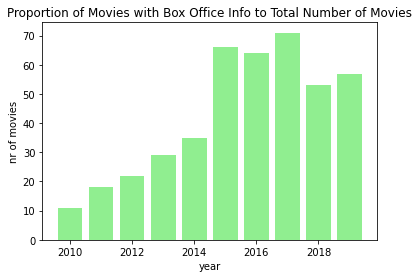

In [40]:
plt.bar(show_stat_per_year.index, show_stat_per_year['proportion'], color='lightgreen')
plt.xlabel('year')
plt.ylabel('nr of movies')
plt.title('Proportion of Movies with Box Office Info to Total Number of Movies')

Более полная картина для 2015-2017 гг (данные представлены для 66 - 71 %). 

In [41]:
# Изучим, как менялась динамика проката по годам, в каком году сумма сборов была минимальной/максимальной.

box_total_per_year = df.groupby('year')['box_office'].sum()
min = box_total_per_year.min()
min_year = box_total_per_year.idxmin()
max = box_total_per_year.max()
max_year = box_total_per_year.idxmax()
print(f'В {min_year} году сумма сборов была минимальной и составила {min} рублей')
print(f'В {max_year} году сумма сборов была максимальной и составила {max} рублей')

В 2010 году сумма сборов была минимальной и составила 2428654.0 рублей
В 2018 году сумма сборов была максимальной и составила 49668403134.31999 рублей


In [42]:
_grouped = df.groupby('year')['box_office'].agg(['mean', 'median'])
_grouped

,mean,median
year,,
2010,"23,130","1,700"
2011,"129,383","3,000"
2012,"54,339","5,660"
2013,"161,955","3,522"
2014,"26,684,415","18,160"
2015,"84,940,570","4,920,933"
2016,"91,000,570","3,846,679"
2017,"136,032,793","9,968,340"
2018,"104,565,059","8,891,102"


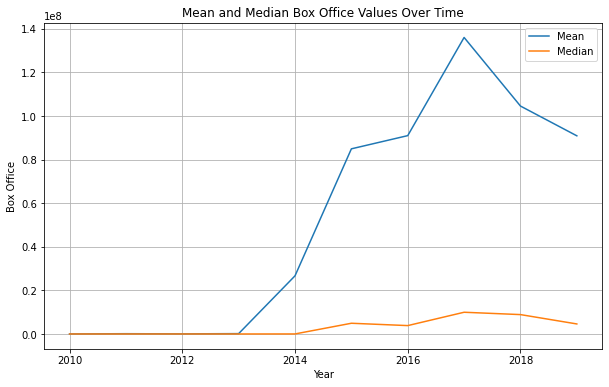

In [43]:
plt.figure(figsize=(10, 6))
_grouped['mean'].plot(label='Mean')
_grouped['median'].plot(label='Median')
plt.title('Mean and Median Box Office Values Over Time')
plt.xlabel('Year')
plt.ylabel('Box Office')
plt.legend()
plt.grid(True)
plt.show()

Проанализируем предоставленные данные о средних и медианных значениях кассовых сборов по годам.

1. Тенденции со временем:
- С 2013 по 2017 год наблюдается значительный рост как средних, так и медианных значений, что указывает на общий восходящий тренд в кассовых сборах за этот период.
- Год 2017 выделяется существенно более высокими значениями по сравнению с предыдущими годами, особенно в отношении среднего значения кассовых сборов, что указывает на то, что в этом году могли быть фльмы с исключительным успехом.
- В 2017 и 2018 годах наблюдается небольшое снижение средних и медианных значений, но они остаются относительно высокими.
2. Выбросы и экстремальные значения:
- 2017 год имеет исключительно высокие средние и медианные значения по сравнению с другими годами. Это может указывать на наличие одного или нескольких блокбастеров, которые значительно исказили общие кассовые сборы за этот год.
3. Сравнение среднего и медианного:
- В большинстве лет среднее значение кассовых сборов выше медианного, что указывает на то, что есть некоторые фильмы с очень высокими кассовыми сборами, которые поднимают среднее значение вверх.
- Разница между средним и медианным значениями меняется от года к году, что указывает на различные уровни асимметрии в распределении кассовых сборов по фильмам в каждом году.

Несмотря на колебания с года на год, средние и медианные значения кассовых сборов в целом демонстрируют увеличение за анализируемый период, что указывает на общий рост в киноиндустрии в терминах кассовых сборов.


In [44]:
# Видно, что за период 2010 - 2014 гг. очень низкое медианное значение по сборам, но это обусловлено тем, что по этим годам у нас менее 50% данных. 

# Определим, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год.
filtered_df = df.query('2015 <= year <= 2019')
filtered_df.groupby('age_restriction')[['box_office']].sum()

,box_office
age_restriction,
0+,"809,077,426"
12+,"60,619,446,628"
16+,"76,034,733,644"
18+,"40,759,615,572"
6+,"55,465,013,740"


Видно, что больше всего сборов у фильмов с рейтингом 16+.

In [45]:
# Проанализируем, как ситуация менялась по годам.
pivot_table = filtered_df.pivot_table(index='year', columns='age_restriction', values='box_office', aggfunc='sum')
pivot_table

age_restriction,0+,12+,16+,18+,6+
year,,,,,
2015,"379,054,578","13,616,082,009","11,368,120,870","5,432,308,367","8,701,799,371"
2016,"150,228,849","12,204,446,524","16,664,548,542","6,793,929,819","12,053,146,008"
2017,"229,598,930","7,851,427,661","18,745,042,900","9,651,495,581","12,086,142,146"
2018,"32,449,002","14,267,291,661","16,503,602,347","8,760,085,501","10,104,974,623"
2019,"17,746,067","12,680,198,774","12,753,418,985","10,121,796,304","12,518,951,591"


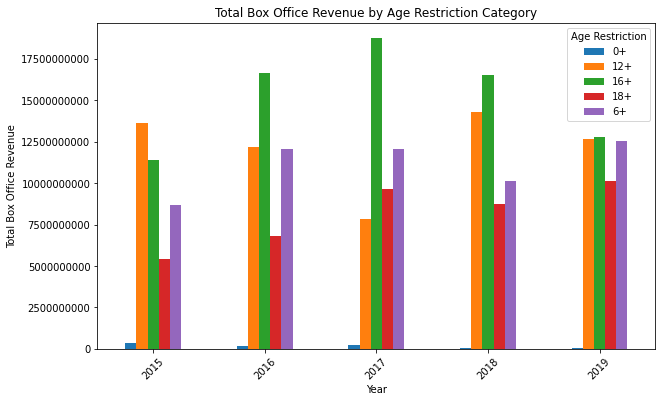

In [46]:
pivot_table.plot(kind='bar', figsize=(10, 6))
plt.title('Total Box Office Revenue by Age Restriction Category')
plt.xlabel('Year')
plt.ylabel('Total Box Office Revenue')
plt.xticks(rotation=45)
plt.legend(title='Age Restriction')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Видно, что сумма сборов существенно различается в зависимости от возрастного ограничения. 
- Наибольшие сборы за все годы наблюдаются у фильмов с возрастным ограничением "12+" и "16+". 
- Фильмы с возрастным ограничением "6+" также показывают высокие сборы, но они не достигают уровня фильмов с ограничением "12+" и "16+". 
- Фильмы без возрастного ограничения ("0+") имеют самые низкие сборы.
- По предоставленным данным, фильмы с возрастным ограничением "16+" имеют самые высокие сборы за весь период с 2015 по 2019 гг.
- Просматривая данные за каждый год, мы видим, что сумма сборов в каждой возрастной категории может меняться с годами. 
Например, сумма сборов фильмов с возрастным ограничением "16+" резко увеличилась в 2016 году, достигла пика в 2017 году, а затем начала постепенно снижаться. Эти изменения могут быть связаны с различными факторами, такими как изменения в предпочтениях аудитории, качество выпущенных фильмов в конкретные годы, маркетинговые стратегии студий и другие факторы.

In [47]:
# Проанализируем также, как ситуация менялась по годам с точки хрения медианных значений.
pivot_table = filtered_df.pivot_table(index='year', columns='age_restriction', values='box_office', aggfunc='median')
pivot_table

age_restriction,0+,12+,16+,18+,6+
year,,,,,
2015,"2,943,319","15,351,562","4,676,819","4,616,615","20,380,982"
2016,"2,571,294","4,690,635","5,133,022","6,107,002","3,026,256"
2017,"22,178,956","9,010,548","9,702,077","8,212,677","51,992,103"
2018,"3,616,937","8,931,966","9,010,639","7,179,466","14,688,850"
2019,"3,885,434","3,405,546","3,210,718","5,603,217","12,525,532"


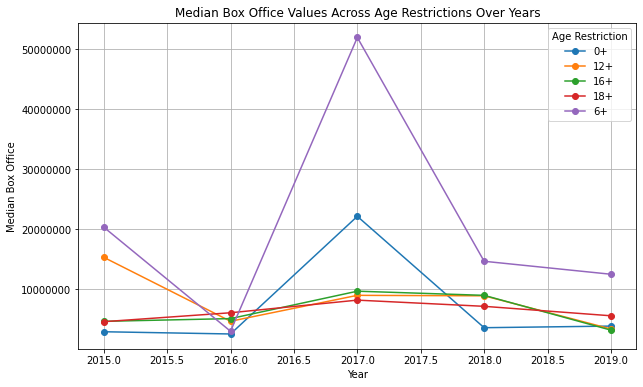

In [48]:
pivot_table.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Median Box Office Values Across Age Restrictions Over Years')
plt.xlabel('Year')
plt.ylabel('Median Box Office')
plt.grid(True)
plt.legend(title='Age Restriction')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

- Для возрастной категории '0+','6+' можно выделить общий тренд роста с 2015 по 2017 год, за которым последовало снижение в 2018 году и небольшое увеличение в 2019 году.
- Для возрастной категории '12+' заметен значительный рост кассовых сборов с 2015 по 2017 год, за которым последовали колебания в 2018 и 2019 годах.
- Возрастные категории '16+' и '18+' также показывают различные паттерны кассовых сборов в течение лет, с колебаниями и отсутствием четкого восходящего или нисходящего тренда.
- В 2017 году наблюдается значительный скачок кассовых сборов во всех возрастных категориях.
Кассовые сборы для возрастной категории '12+' кажутся стабильно более высокими, чем для других категорий, в большинство лет, за исключением 2017 года, где кассовые сборы для категории '16+' значительно выше.

Несмотря на колебания с года на год, в целом данные показывают смешанный результат в течение разных лет для киноиндустрии в терминах кассовых сборов в разных возрастных категориях.

#### Промежуточный вывод 3: ### 
1. Произведён исследовательский анализ данных.
- Выявлено, что общая доля фильмов с указанной информацией о прокате в кинотеатрах составляет 42%.
- Более полная картина для 2015-2017 гг (данные представлены для 66 - 71 %). 
- В 2010 году сумма сборов была минимальной и составила 2428654.0 рублей
- В 2018 году сумма сборов была максимальной и составила 49668403134.32 рублей
2. Проанализированы данные по возрастным ограничениям в период 2015 - 2019 гг. 
- Выявлено, что наибольшие сборы за все годы наблюдаются у фильмов с возрастным ограничением "12+" и "16+". 
- Фильмы с возрастным ограничением "18+" также показывают высокие сборы, но они не достигают уровня фильмов с ограничением "12+" и "16+". 
- Фильмы без возрастного ограничения ("0+") имеют самые низкие сборы.
- Сумма сборов в каждой возрастной категории менялась с годами (например, сумма сборов фильмов с возрастным ограничением "16+" резко увеличилась в 2016 году, достигла пика в 2017 году, а затем начала постепенно снижаться). 
- Такие изменения могут быть связаны с различными факторами, такими как изменения в предпочтениях аудитории, качество выпущенных фильмов в конкретные годы, маркетинговые стратегии студий и другие факторы.

### 1.4 Исследование фильмов, которые получили государственную поддержку

In [49]:
# Посчитаем сколько всего было выделено средств.
total_support = df['refundable_support'].sum() + df['nonrefundable_support'].sum()
print("Общий объем выделенных средств на поддержку кино: ", total_support)

# Посмотрим, насколько хорошо окупаются фильмы с государственной поддержкой.
# Для этого можно посчитать отношение сборов в прокате к общему бюджету фильма.
df['revenue_to_budget_ratio'] = df['box_office'] / df['budget']
print("Средний коэффициент окупаемости фильмов с государственной поддержкой: ", round(df['revenue_to_budget_ratio'].mean(), 2))

# Посмотрим на рейтинги фильмов.
# Мы можем вывести средний рейтинг всех фильмов.
average_rating = round(df.loc[df['budget'].notna(), 'ratings'].mean())
print("Средний рейтинг фильмов с государственной поддержкой: ", average_rating)

Общий объем выделенных средств на поддержку кино:  19930688312.0
Средний коэффициент окупаемости фильмов с государственной поддержкой:  0.83
Средний рейтинг фильмов с государственной поддержкой:  6


В среднем фильмы с государственной поддержкой окупают около 83% своего общего бюджета через сборы в прокате.

Это хороший показатель, который говорит о том, что вложенные средства в киноиндустрию частично возвращаются через кассовые сборы, и фильмы с государственной поддержкой в среднем приносят доход. Однако это также означает, что около 17% бюджета фильма не окупается за счёт сборов в прокате, что может быть неблагоприятным показателем для инвесторов или организаций, предоставляющих государственную поддержку.

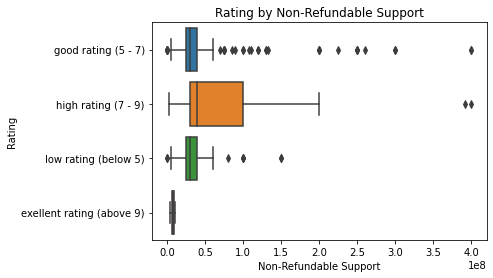

In [50]:
# Видим, что средний рейтинг 6, Однако, хочу взглянуть более детально. 
# Существует гипотеза, что при высоких объёмах не возвратных средств, фильмы получаются не получают высокий рейтинг. Проверим её.
# Посмотрим есть ли какие-то интересные закономерности в зависимости рецтинга от гос. поддержки.

def rating_category(rating):
    if 0 < rating < 5:
        return 'low rating (below 5)'
    elif 5 <= rating < 7.5:
        return 'good rating (5 - 7)'
    elif  7.5 <= rating < 9:
        return 'high rating (7 - 9)'
    elif 9 <= rating <= 10:
        return 'exellent rating (above 9)'

df['rating_category'] = df['ratings'].apply(rating_category)

sns.boxplot(data=df, x='nonrefundable_support', y='rating_category')
plt.title('Rating by Non-Refundable Support')
plt.xlabel('Non-Refundable Support')
plt.ylabel('Rating')
plt.show()

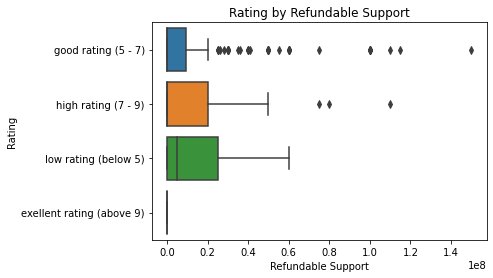

In [51]:
sns.boxplot(data=df, x='refundable_support', y='rating_category')

plt.title('Rating by Refundable Support')
plt.xlabel('Refundable Support')
plt.ylabel('Rating')
plt.show()

In [52]:
df['total_support'] = df['refundable_support'] + df['nonrefundable_support']
df.groupby('rating_category')['total_support'].sum()

rating_category
exellent rating (above 9)       14,700,000
good rating (5 - 7)         13,834,233,569
high rating (7 - 9)          2,774,161,363
low rating (below 5)         2,618,623,915
Name: total_support, dtype: float64

В целом, можно увидеть, что большинство фильмов имеют неплохой рейтинг, даже при невысоких объёмах выделенных средств (как возвратной, так и невозвратной поддержки), также при более высоких бюджетах, рейтинг также находится в этом диапазоне,  что показыает, что гипотеза не подтвердилась.

Примечательно, что есть даже неколько вариантов очень высокого рейтинга даже при низких бюджетах.

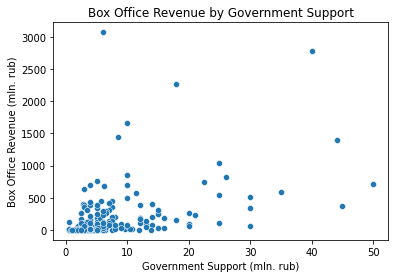

In [53]:
# Посмотрим также на зависимость сборов от гос. поддержки.
df['box_office_mln'] = df['box_office'] / 1000000
df['total_support_mln'] = df['total_support'] / 10000000
sns.scatterplot(data=df, x='total_support_mln', y='box_office_mln')

plt.title('Box Office Revenue by Government Support')
plt.xlabel('Government Support (mln. rub)')
plt.ylabel('Box Office Revenue (mln. rub)')
plt.show()

In [54]:
df['box_office'].corr(df['total_support'])

0.49059163763791824

Коэффициент корреляции 0.4906 указывает на умеренную положительную линейную зависимость между сборами и поддержкой, но связь не является идеальной.

In [55]:
# Выберем топ 10 режисеров с наибольшей суммой гос.поддержки.
directors_top = df.groupby('director_primary')[['total_support']].agg('sum').sort_values(by='total_support', ascending=False)[:10]
directors_top

,total_support
director_primary,
Ф.Бондарчук,"750,000,000"
Н.Хомерики,"660,000,000"
А.Кравчук,"500,000,000"
Р.Давлетьяров,"459,847,945"
А.Мизгирев,"450,000,000"
Н.Лебедев,"442,104,482"
А.Мегердичев,"400,000,000"
Д.Дьяченко,"351,000,000"
И.Шурховецкий,"350,000,000"


In [56]:
# Посмотрим на их средний рейтинг и среднюю окупаемость
_filtered = df.loc[df['director_primary'].isin(directors_top.index)]
directors_top_rating = _filtered.groupby('director_primary')[['ratings','revenue_to_budget_ratio']].agg('mean').sort_values(by='ratings',ascending=False)
directors_top_rating

,ratings,revenue_to_budget_ratio
director_primary,,
Н.Лебедев,8,2
А.Мизгирев,7,1
Р.Давлетьяров,7,0
А.Кравчук,6,1
И.Шурховецкий,6,1
А.Мегердичев,6,5
Н.Хомерики,6,2
А.Цицилин,6,1
Д.Дьяченко,6,3


In [57]:
#  Объединим две предыдущие таблицы
directors_top_merged = directors_top.merge(directors_top_rating, on='director_primary', how='outer')
directors_top_merged.sort_values(by='ratings', ascending=False)

,total_support,ratings,revenue_to_budget_ratio
director_primary,,,
Н.Лебедев,"442,104,482",8,2
А.Мизгирев,"450,000,000",7,1
Р.Давлетьяров,"459,847,945",7,0
А.Кравчук,"500,000,000",6,1
И.Шурховецкий,"350,000,000",6,1
А.Мегердичев,"400,000,000",6,5
Н.Хомерики,"660,000,000",6,2
А.Цицилин,"350,000,000",6,1
Д.Дьяченко,"351,000,000",6,3


In [58]:
# Попробуем посмотреть окупаемость фильмов этих режисёров по годам
_filtered = df.loc[(df['director_primary'].isin(directors_top.index)) & (df['total_support'].notna())]
_grouped = _filtered.pivot_table(index='year', columns='director_primary', values='revenue_to_budget_ratio', aggfunc='mean')
_grouped

director_primary,А.Кравчук,А.Мегердичев,А.Мизгирев,А.Цицилин,Д.Дьяченко,И.Шурховецкий,Н.Лебедев,Н.Хомерики,Р.Давлетьяров,Ф.Бондарчук
year,,,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2014,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
2015,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,0,NaN
2016,NaN,NaN,1,0,2,NaN,2,1,NaN,4
2017,NaN,5,NaN,NaN,5,1,NaN,NaN,NaN,NaN
2018,NaN,NaN,NaN,1,1,NaN,NaN,4,NaN,NaN
2019,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


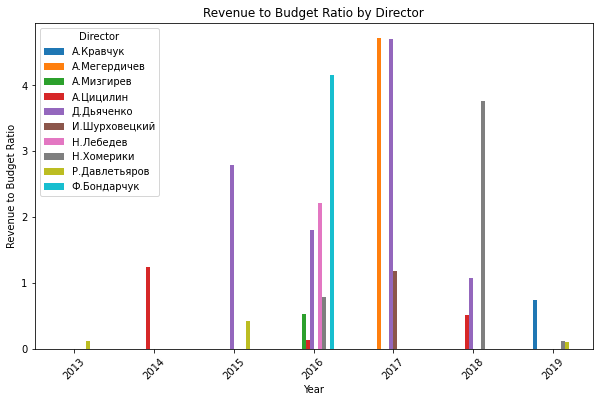

In [59]:
# Есть много пропусков, но попробуем посомтреть на визуализацию
_grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Revenue to Budget Ratio by Director')
plt.xlabel('Year')
plt.ylabel('Revenue to Budget Ratio')
plt.xticks(rotation=45)
plt.legend(title='Director')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Для анализа окупаемости режисеров, которые получиили поддержку, данных не сильно много, однако, можно выделить, что есть режисеры с очень большой окупаемостью (А.Мегердичев, Д.Дяченко, С.Андреасян) 

In [60]:
# Посмотрим какие международные проекты выделялись средства, выведем топ стран участвующих в производстве
_q1 = df['total_support'].notnull()
_q2 = df['production_country'] != 'Россия'
international = df[_q1 & _q2]

In [61]:
international.groupby('production_country')[['total_support','revenue_to_budget_ratio']].mean().sort_values(by='total_support', ascending=False)

,total_support,revenue_to_budget_ratio
production_country,,
"Россия, Италия","60,000,000",0
"Россия, Армения","50,000,000",0
"Россия, Германия, Великобритания","50,000,000",0
"Россия, Франция, Латвия","46,502,299",0
"Россия, Сербия","35,000,000",2
"Россия, Германия","31,500,000",0
"Россия, Бельгия, Финляндия","30,000,000",NaN
"Россия, Украина, Польша","30,000,000",0
Россия-Словакия-Чехия,"30,000,000",0


Вижу, что многие не окупились.

#### Общий вывод: ### 
В ходе анализа рынка российского кинопроката для Министерства культуры Российской Федерации были проведены следующие шаги:

- Проведено изучение данных, их предобработка и объединение в один датафрейм.
- Проверены типы данных, устранены дубликаты и обработаны пропущенные значения.
- Проанализирована динамика кинопроката по годам, выявлены минимальные и максимальные суммы сборов за период (2 428 654.0 рублей и 49 668 403 134.32 рублей соответственно)
- Исследовано влияние возрастного ограничения аудитории на сборы в прокате. Выявлено, что фильмы с возрастным ограничением "12+" и "16+" имеют наибольшие сборы.
- Осуществлен анализ фильмов, получивших государственную поддержку. Выявлено, что большинство фильмов имеют неплохой рейтинг (5-7), и 83% бюджета фильма окупается через сборы в прокате.
- Посчитан коэффициент корреляции между сборами и поддержкой. Обнаружена умеренная положительная линейная зависимость.

В целом, результаты анализа позволяют сделать вывод, что российский кинопрокат активно развивается, существует востребованность фильмов с различными возрастными ограничениями, а государственная поддержка в значительной степени влияет на успешность кинопроектов.

Заказчику можно порекомендовать продолжить инвестировать в развитие кинематографической инфраструктуры.
Для расширения международного влияния и продвижения российского кинематографа за пределы страны, рекомендуется активно развивать партнерские отношения с международными кинокомпаниями, участвовать в международных кинофестивалях и продвигать российские фильмы на мировой арене.